# CT Scan lung segmentation using U-Net

Code inspiré fortement de : https://www.kaggle.com/code/akshat0007/covid-19-lung-ct-scan-segmentation

## Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf #for deep learning

## Link to google drive upload data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


## Read data

In [4]:
data = pd.read_csv('input/covid19-ct-scans/metadata.csv')
data.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,input/covid19-ct-scans/ct_scans/coronacases_or...,input/covid19-ct-scans/lung_mask/coronacases_0...,input/covid19-ct-scans/infection_mask/coronaca...,input/covid19-ct-scans/lung_and_infection_mask...
1,input/covid19-ct-scans/ct_scans/coronacases_or...,input/covid19-ct-scans/lung_mask/coronacases_0...,input/covid19-ct-scans/infection_mask/coronaca...,input/covid19-ct-scans/lung_and_infection_mask...
2,input/covid19-ct-scans/ct_scans/coronacases_or...,input/covid19-ct-scans/lung_mask/coronacases_0...,input/covid19-ct-scans/infection_mask/coronaca...,input/covid19-ct-scans/lung_and_infection_mask...
3,input/covid19-ct-scans/ct_scans/coronacases_or...,input/covid19-ct-scans/lung_mask/coronacases_0...,input/covid19-ct-scans/infection_mask/coronaca...,input/covid19-ct-scans/lung_and_infection_mask...
4,input/covid19-ct-scans/ct_scans/coronacases_or...,input/covid19-ct-scans/lung_mask/coronacases_0...,input/covid19-ct-scans/infection_mask/coronaca...,input/covid19-ct-scans/lung_and_infection_mask...


This function read the different data : 

*   Ct Scan
*   Lung mask
*   Infection mask
*   Both mask

In [5]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [6]:
# Read sample
sample_ct   = read_nii(data.loc[1,'ct_scan'])
sample_lung = read_nii(data.loc[1,'lung_mask'])
sample_infe = read_nii(data.loc[1,'infection_mask'])
sample_all  = read_nii(data.loc[1,'lung_and_infection_mask'])

## Visualization of the different data

Text(0.5, 1.0, 'Lung and Infection Mask')

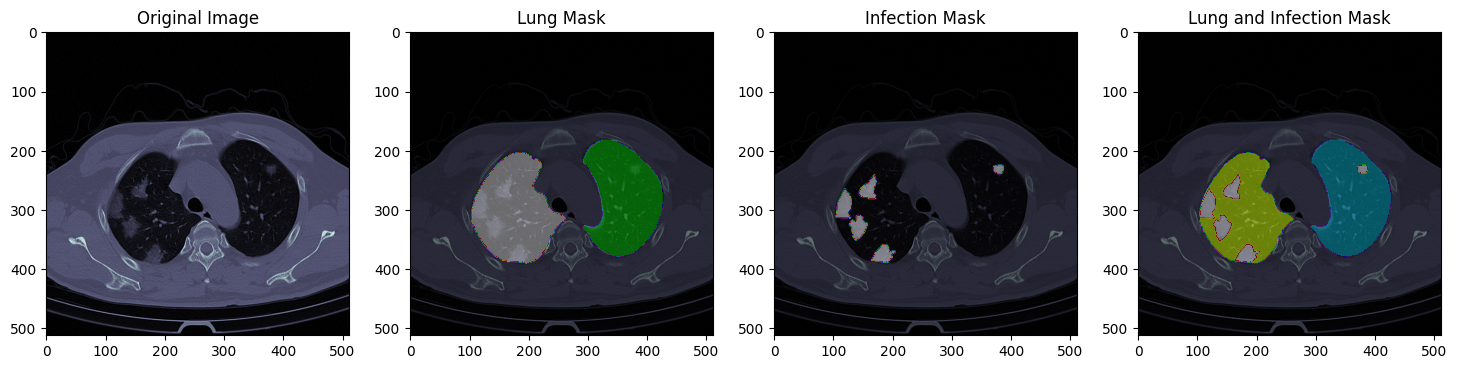

In [7]:
indice = 150
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., indice], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., indice], cmap = 'bone')
plt.imshow(sample_lung[..., indice],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., indice], cmap = 'bone')
plt.imshow(sample_infe[..., indice], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., indice], cmap = 'bone')
plt.imshow(sample_all[..., indice], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

Converting data into array for training model

In [8]:
lungs = []
infections = []
img_size = 128

for i in range(len(data)):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    for ii in range(ct.shape[0]):
        lung_img = cv2.resize(ct[ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])

In [9]:
lungs = np.array(lungs)
infections = np.array(infections)

## Performing test and train split

In [10]:
from sklearn.model_selection import train_test_split
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.1)

# Architecture models : some examples

Classification example with tensorflow : https://www.tensorflow.org/tutorials/keras/classification

# Building the U-Net architecture for the segmentation
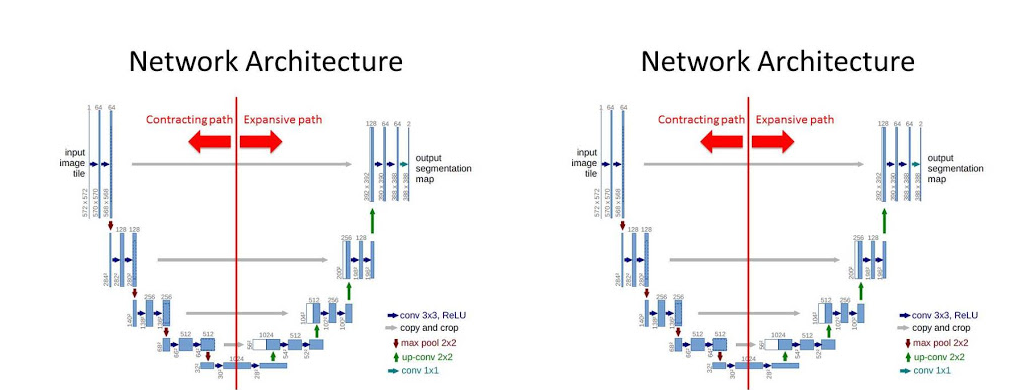

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.

The U-Net architecture stems from the so-called “fully convolutional network” first proposed by Long and Shelhamer.

The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What's more, a successive convolutional layer can then learn to assemble a precise output based on this information.

One important modification in U-Net is that there are a large number of feature channels in the upsampling part, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting part, and yields a u-shaped architecture. The network only uses the valid part of each convolution without any fully connected layers. To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image. This tiling strategy is important to apply the network to large images, since otherwise the resolution would be limited by the GPU memory.

Source: https://en.wikipedia.org/wiki/U-Net

Layers informations : https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [11]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

In [12]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

## Training the model
10 training iterations (epochs = 10)

In [13]:
history = model.fit(lung_train, infect_train, epochs = 10, validation_data = (lung_test, infect_test))

Epoch 1/10
315/315 [==============================] - 1471s 5s/step - loss: 0.0390 - accuracy: 0.9903 - val_loss: 0.0264 - val_accuracy: 0.9923
Epoch 2/10
315/315 [==============================] - 1486s 5s/step - loss: 0.0182 - accuracy: 0.9932 - val_loss: 0.0160 - val_accuracy: 0.9939
Epoch 3/10
315/315 [==============================] - 1470s 5s/step - loss: 0.0126 - accuracy: 0.9954 - val_loss: 0.0115 - val_accuracy: 0.9956
Epoch 4/10
315/315 [==============================] - 1466s 5s/step - loss: 0.0103 - accuracy: 0.9961 - val_loss: 0.0104 - val_accuracy: 0.9959
Epoch 5/10
315/315 [==============================] - 1454s 5s/step - loss: 0.0090 - accuracy: 0.9964 - val_loss: 0.0090 - val_accuracy: 0.9963
Epoch 6/10
315/315 [==============================] - 1433s 5s/step - loss: 0.0083 - accuracy: 0.9966 - val_loss: 0.0088 - val_accuracy: 0.9963
Epoch 7/10
315/315 [==============================] - 1436s 5s/step - loss: 0.0076 - accuracy: 0.9969 - val_loss: 0.0082 - val_accuracy:

## Plotting the performance metrics

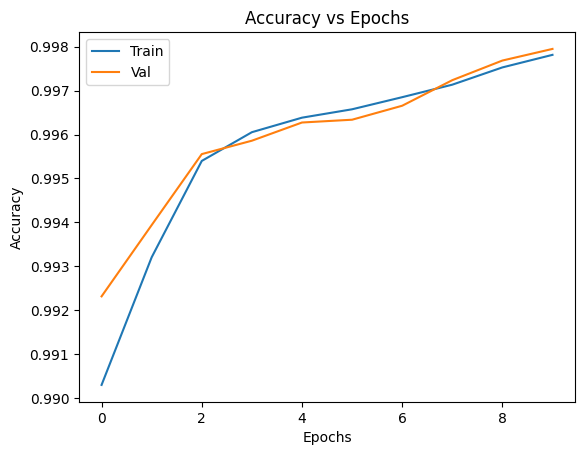

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

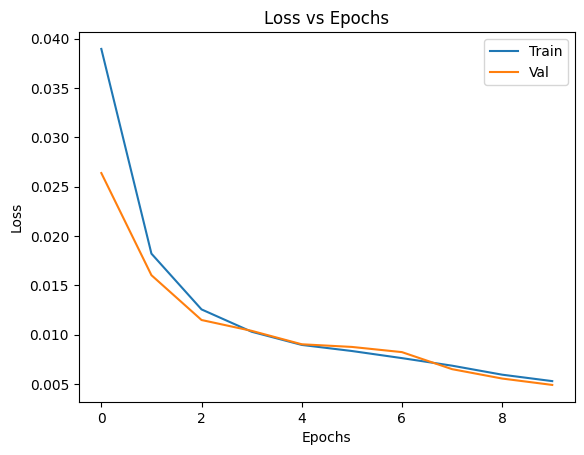

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

## Trained model used for prediction

35/35 [==============================] - 37s 1s/step


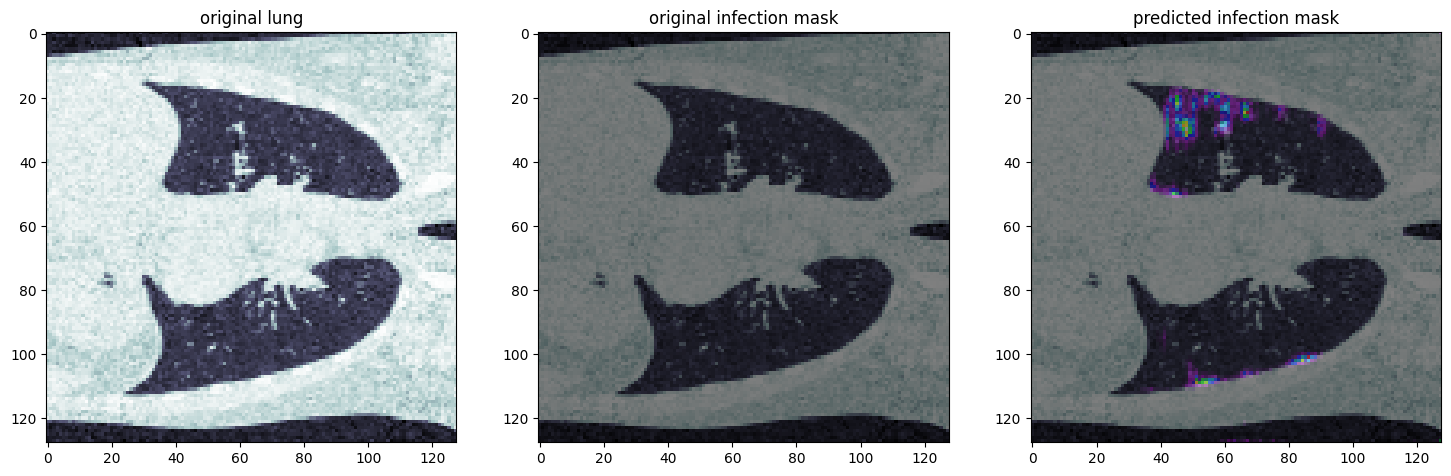

In [16]:
predicted = model.predict(lung_test)
fig = plt.figure(figsize = (18,15))


for i in range(len(lung_test)):
    plt.subplot(1,3,1)
    plt.imshow(lung_test[i][...,0], cmap = 'bone')
    plt.title('original lung')

    plt.subplot(1,3,2)
    plt.imshow(lung_test[i][...,0], cmap = 'bone')
    plt.imshow(infect_test[i][...,0],alpha = 0.5, cmap = "nipy_spectral")
    plt.title('original infection mask')

    plt.subplot(1,3,3)
    plt.imshow(lung_test[i][...,0], cmap = 'bone')
    plt.imshow(predicted[i][...,0],alpha = 0.5,cmap = "nipy_spectral")
    plt.title('predicted infection mask')